# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.699618,True,8.476413
1,0.164785,False,0.995393
2,1.446322,True,9.414950
3,1.858745,True,8.116729
4,2.339453,True,8.173810
...,...,...,...
995,0.428451,False,1.943005
996,0.041397,False,0.661395
997,1.839660,False,2.382140
998,0.156088,False,0.008426


<AxesSubplot: xlabel='v0'>

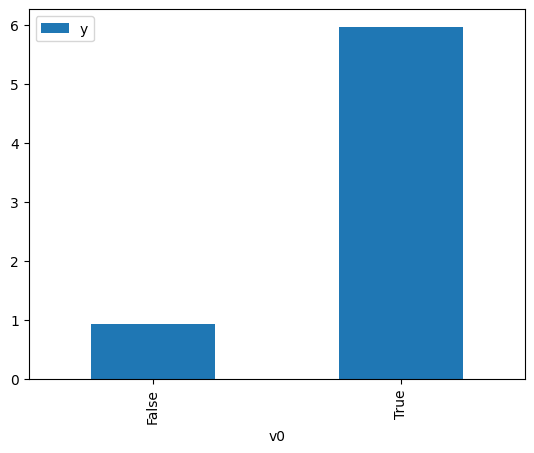

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

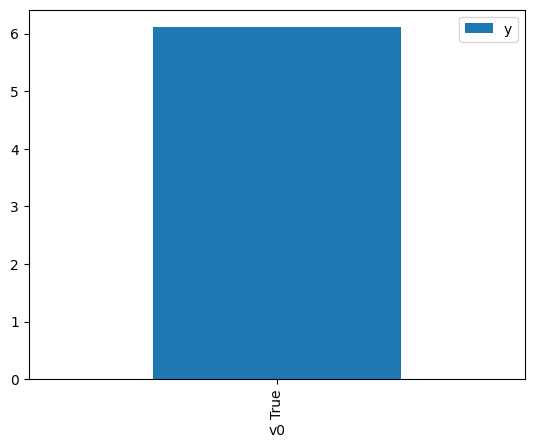

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.598707,False,1.520060,0.460447,2.171802
1,1.247679,False,2.178332,0.411907,2.427731
2,0.029824,False,1.029678,0.503655,1.985484
3,-0.206798,False,-1.496934,0.521649,1.916999
4,0.237217,False,-0.676592,0.487876,2.049703
...,...,...,...,...,...
995,1.339368,False,-0.052740,0.405163,2.468140
996,2.273854,False,3.744395,0.338844,2.951207
997,0.151600,False,-0.121714,0.494389,2.022700
998,1.638179,False,1.240243,0.383445,2.607938


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.280194,True,5.873533,0.590488,1.693514
1,2.482466,True,8.785363,0.675233,1.480971
2,1.462090,True,7.483441,0.603807,1.656159
3,-0.283367,True,3.869727,0.472539,2.116228
4,1.195127,True,6.940165,0.584212,1.711706
...,...,...,...,...,...
995,-0.746033,True,3.502553,0.437629,2.285038
996,-0.111351,True,4.197917,0.485605,2.059286
997,0.868924,True,8.249733,0.559910,1.786002
998,1.171077,True,6.601769,0.582433,1.716936


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                          1.187e+04
Date:                Wed, 09 Nov 2022   Prob (F-statistic):                        0.00
Time:                        17:21:08   Log-Likelihood:                         -1417.8
No. Observations:                1000   AIC:                                      2840.
Df Residuals:                     998   BIC:                                      2849.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6660      0.031     53.420      0.000       1.605       1.727
x2             5.0013      0.049    102.532      0.000       4.906       5.097
==============================================================================
Omnibus:                        2.182   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.336   Jarque-Bera (JB):                2.117
Skew:                          -0.061   Prob(JB):                        0.347
Kurtosis:                       3.190   Cond. No.                         1.99
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""